In [1]:
import torch
import scanpy as sc
import celldiffusion as cd


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name())

cuda
NVIDIA L40S


In [3]:
DATA_PATH = '/projectnb/czlab/A00/ycliu/scRNA_clustering_benchmark_datasets/Cortex/'

OUTPUT_PATH = 'outputs/'

# Load dataset

In [4]:
adata = sc.read_h5ad(DATA_PATH + 'cortex.h5ad')
adata

AnnData object with n_obs × n_vars = 3005 × 19972
    obs: 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types'

# Preprocess

/usr2/postdoc/ycliu137/.conda/envs/diffusion_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


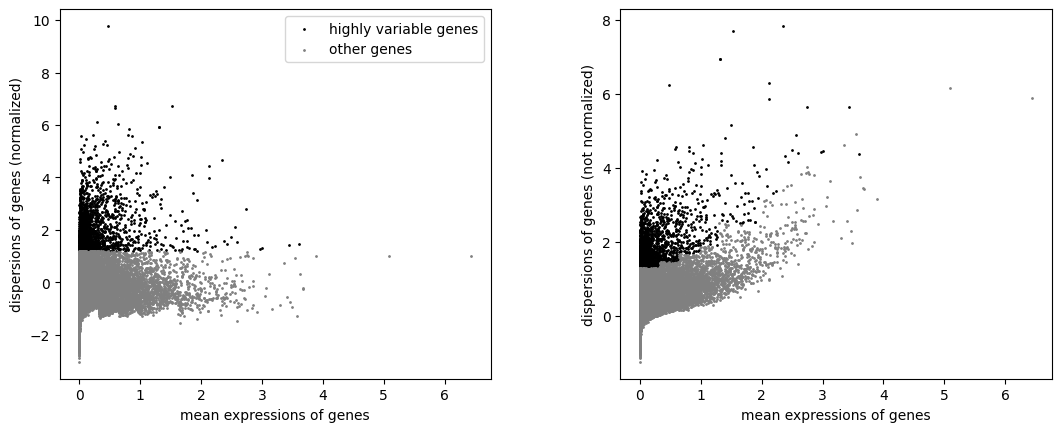

In [5]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [6]:
adata.raw = adata

adata = adata[:, adata.var.highly_variable]
adata


View of AnnData object with n_obs × n_vars = 3005 × 2000
    obs: 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

We use the normalized and log transformed data (NOT scaled data).

# Feature encoder

In [7]:
cd.encode_features(adata, 
                   D_encode_list=[2000, 300, 50], # Encoder dimension in each layer
                   D_decode_list=[50, 300, 2000], # Decoder dimension in each layer
                   max_epoch=2000, # number of epoch
                   lr=1e-3,        # learning rate
                   device=device)


2025-07-21 10:01:43,174 - --------> Starting feature encoder ...
/projectnb/czproj/Algorithms/ycliu/Pan_proj/diffusion/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)
2025-07-21 10:01:44,812 - ------------------------> Epoch: 1/2000, Current loss: 1423193.2500
2025-07-21 10:01:45,018 - ------------------------> Epoch: 51/2000, Current loss: 515894.3750
2025-07-21 10:01:45,221 - ------------------------> Epoch: 101/2000, Current loss: 444082.1562
2025-07-21 10:01:45,424 - ------------------------> Epoch: 151/2000, Current loss: 410478.0000
2025-07-21 10:01:45,628 - ------------------------> Epoch: 201/2000, Current loss: 393537.3750
2025-07-21 10:01:45,833 - ------------------------> Epoch: 251/2000, Current loss: 382576.5625
202

## Check isolated nodes (Not necessary)

In [8]:
cd.util.evaluate_node_isolation(adata, 
                                use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                                predict_pct=0.2) # Isolated nodes ratio.

The isolation inofrmation can be used to prune edges for single cell graph.

# Diffusion

In [9]:
# This graph provides the adjacency that will be used in diffusion loss function.
cd.graph.build_adj_graph(adata, 
                         use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                         k=50,            # K for building a KNN graph.
                         device=device)

In [10]:
cd.graph.build_diffusion_graph(adata, 
                               use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                               k=50,            # K for building a KNN graph.
                               prune=False,     # If True, prune graph edges for isolated nodes.
                               device=device)


This graph is used in the graph neural diffusion process.

If prune=True, edges will be pruned according to the isolation labels for graph-nodes.

In [11]:
cd.graph_diffusion(adata, 
                   use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                   max_epoch=2000,  # Number of epoch
                   lr=1e-3,         # Learning rate.
                   time_increment_diffusion=0.1,  # Suggest value >0.0 & <=0.5. Larger value indicates stronger feature diffusion. 
                   loss_adj=0.0,      # value 0 will recover the input data; value 1 will recover input KNN adjacency.
                   edge_rewire=False, # If True, rebuild KNN graph in each diffusion layer.
                   device=device)


2025-07-21 10:01:53,179 - --------> Starting graph nueral diffusion ...
/projectnb/czproj/Algorithms/ycliu/Pan_proj/diffusion/graph_DIF.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(adjacency, dtype = recon_adj.dtype)
/projectnb/czproj/Algorithms/ycliu/Pan_proj/diffusion/graph_DIF.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_2 = torch.tensor(target_features, dtype = out_nodes_features.dtype)
2025-07-21 10:01:53,298 - ------------------------> Epoch: 1/2000, Current loss: 3077040.0000
2025-07-21 10:01:54,945 - ------------------------> Epoch: 51/2000, Current loss: 509938.8125
2025-07-21 10:01:56,591 - ------------------------> Epoch: 101/20

Edge rewiring during the diffusion process typically increases the separation between cell groups while making each group more condensed. Set edge_rewire to True if you want to organize your data into more distinct clusters. Setting edge_rewire to False may preserve more inter-cluster relationships and appreciably accelerate the training process.

## View UMAP for diffused embeddings

In [12]:
sc.pp.neighbors(adata, use_rep='X_dif', n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/usr2/postdoc/ycliu137/.conda/envs/diffusion_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


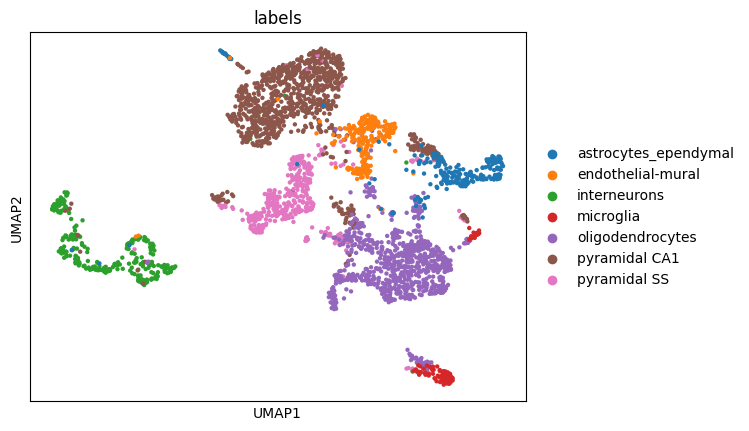

In [13]:
sc.pl.umap(adata, color=['labels'])

# Clustering

In [14]:
cd.graph.build_graph(adata, use_rep="X_dif", k=50, device=device)  # build KNN graph for clustering

In [15]:
cd.graph.call_attention(adata, device=device)  # generate cell-cell attention network

In [16]:
cd.anal.att_leiden(adata, resolution=0.5)      # Leiden clustering based on cell-cell attentions.

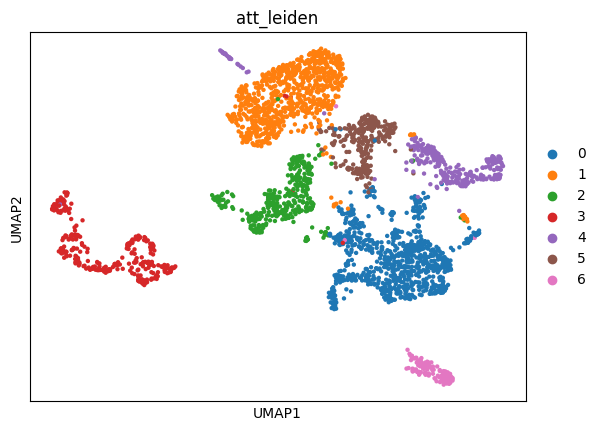

In [17]:
sc.pl.umap(adata, color=['att_leiden'])

# Save data

In [18]:
adata.write(OUTPUT_PATH+'scDiffusion_adata.h5ad')

In [19]:
adata = sc.read_h5ad(OUTPUT_PATH+'scDiffusion_adata.h5ad')